# Instructions

* This notebook is refered to MScFE 690 Capstone - Module 4 - Design and it is finished and running succefully, for an ongoing updated code go to the vLive version.
* Since the notebook requires the instalation of modules it is required to restart the sessions afer the modules are installed.


In [1]:
import requests
import pandas as pd
import os
import time
from datetime import date
import json
import re
import yfinance
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import requests

try:
  import quiverquant
except:
  !pip install quiverquant
  import quiverquant

try:
  from massive import RESTClient
except:
  !pip install massive
  from massive import RESTClient

In [2]:
# Create output directory
os.makedirs("data", exist_ok=True)

# Data collection

In [3]:

POLYGON_KEY = "ft2rquZoprD0MSBmJqQfD_8qNsxrkK_1"
ALPHA_VANTAGE_KEY = "2SX1EVZURUMJYBSY"
FMP_KEY = "VbhiVfD0updeGFAAeonlZmXVThNARJJe"

## Polygon data

In [4]:
client = RESTClient(api_key=POLYGON_KEY)

In [5]:
aggs = []
for a in client.list_aggs(
    "AAPL",
    1,
    "minute",
    "2024-01-01",
    "2024-02-03",
    limit=50000,
):
    aggs.append(a)


In [6]:
df = pd.DataFrame(aggs)
df.head()

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,192.18,192.18,191.56,191.93,2529.0,191.9193,1705914000000,127,None
1,191.99,191.99,191.99,191.99,1363.0,191.9969,1705914060000,122,None
2,191.90,191.90,191.80,191.80,1376.0,191.8235,1705914120000,39,None
3,191.75,191.86,191.75,191.86,773.0,191.7898,1705914180000,25,None
4,191.85,191.85,191.83,191.84,1509.0,191.8414,1705914300000,35,None


## Yfinance data

In [7]:
# 1. Fetch Data
ticker = "NVDA"
df = yfinance.download(ticker, period="1y", interval="1d")
df = df.stack(level='Ticker').reset_index()

# 2. Create Subplots (2 Rows: Price on top, Volume on bottom)
# row_heights=[0.7, 0.3] gives 70% space to Price, 30% to Volume
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=(f'{ticker} Price', 'Volume'),
    row_heights=[0.7, 0.3]
)

# 3. Add Candlestick Trace (Row 1)
fig.add_trace(go.Candlestick(
    x=df.Date,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Price'
), row=1, col=1)

# 4. Add Volume Trace (Row 2)
# We color the volume bars based on price change (Green for up, Red for down)
colors = ['green' if row['Open'] - row['Close'] >= 0
          else 'red' for index, row in df.iterrows()]

fig.add_trace(go.Bar(
    x=df.Date,
    y=df['Volume'],
    marker_color=colors,
    name='Volume'
), row=2, col=1)

# 5. Add Moving Average (Optional, on Row 1)
df['MA20'] = df['Close'].rolling(window=20).mean()
fig.add_trace(go.Scatter(
    x=df.Date,
    y=df['MA20'],
    line=dict(color='orange', width=2),
    name='20-Day MA'
), row=1, col=1)

# 6. Final Layout Adjustments
fig.update_layout(
    title=f'{ticker} Candlestick Chart with Volume',
    template='plotly_dark',
    xaxis_rangeslider_visible=False, # Hides the slider (redundant with zoom)
    height=800 # Taller figure to accommodate both plots
)

# Show the Plot
fig.show()

/tmp/ipython-input-2028394315.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yfinance.download(ticker, period="1y", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2028394315.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(level='Ticker').reset_index()


In [8]:
df = yfinance.download(ticker, period="1y", interval="1d", ignore_tz=True)

/tmp/ipython-input-3256998864.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [9]:
clean_df = df.stack(level='Ticker').reset_index()
clean_df.head()

/tmp/ipython-input-1590771923.py:1: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



Price,Date,Ticker,Close,High,Low,Open,Volume
0,2025-01-17,NVDA,137.672348,138.462125,135.422963,136.652623,201188800
1,2025-01-21,NVDA,140.791489,141.791215,137.052506,139.121947,197749000
2,2025-01-22,NVDA,147.029800,147.749590,143.630721,144.620456,237651400
3,2025-01-23,NVDA,147.179749,147.189740,143.680706,145.010344,155915500
4,2025-01-24,NVDA,142.581009,148.929279,141.841221,148.329437,234657600


## AlphaVantage news data

In [10]:
ticker = "AAPL"
start = "20220410T0130"
end = "20220417T0130"
url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={ticker}&apikey={ALPHA_VANTAGE_KEY}&time_from={start}&time_to={end}"
r = requests.get(url)
data = r.json()


In [11]:
news = pd.DataFrame(data)
news.feed[0]

{'title': 'Apple helps suppliers rapidly accelerate renewable energy use around the world',
 'url': 'https://www.apple.com/newsroom/2022/04/apple-helps-suppliers-rapidly-accelerate-renewable-energy-use-around-the-world/',
 'time_published': '20220414T182544',
 'authors': [],
 'summary': 'Apple announced that its suppliers more than doubled their use of clean power over the last year, with over 10 gigawatts operational out of nearly 16 gigawatts committed. 213 major manufacturing partners have pledged to power all Apple production with renewable electricity across 25 countries, accelerating progress toward Apple’s 2030 carbon neutral goal. Apple is also investing directly in renewable energy projects globally and supporting communities through its Power for Impact program.',
 'banner_image': None,
 'source': 'Apple',
 'category_within_source': 'General',
 'source_domain': 'Apple',
 'topics': [{'topic': 'technology', 'relevance_score': '0.821962'},
  {'topic': 'energy_transportation', 'r

## FMP financial statement data

In [12]:
def get_financials_fmp(ticker, api_key):
    # FMP Endpoint for Income Statement (limit=5 gets last 5 years)
    url = f"https://financialmodelingprep.com/stable/financial-reports-json?symbol={ticker}&year=2022&period=FY&apikey={api_key}"

    try:
        response = requests.get(url)
        data = response.json()
        return data

    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

In [13]:
statement_aapl = get_financials_fmp("AAPL", FMP_KEY)

In [14]:
statement_aapl

{'symbol': 'AAPL',
 'period': 'FY',
 'year': '2022',
 'Cover Page': [{'Cover Page - USD ($) shares in Thousands, $ in Millions': ['12 Months Ended']},
  {'items': ['Sep. 24, 2022', 'Oct. 14, 2022', 'Mar. 25, 2022']},
  {'Entity Information [Line Items]': ['\xa0', '\xa0', '\xa0']},
  {'Document Type': ['10-K', '\xa0', '\xa0']},
  {'Document Annual Report': ['true', '\xa0', '\xa0']},
  {'Current Fiscal Year End Date': ['--09-24', '\xa0', '\xa0']},
  {'Document Period End Date': ['Sep. 24,  2022', '\xa0', '\xa0']},
  {'Document Transition Report': ['false', '\xa0', '\xa0']},
  {'Entity File Number': ['001-36743', '\xa0', '\xa0']},
  {'Entity Registrant Name': ['Apple Inc.', '\xa0', '\xa0']},
  {'Entity Incorporation, State or Country Code': ['CA', '\xa0', '\xa0']},
  {'Entity Tax Identification Number': ['94-2404110', '\xa0', '\xa0']},
  {'Entity Address, Address Line One': ['One Apple Park Way', '\xa0', '\xa0']},
  {'Entity Address, City or Town': ['Cupertino', '\xa0', '\xa0']},
  {'Enti

## Quiver transaction history

In [15]:
class CustomQuiver(quiverquant.quiver):

    def congress_trading(self, ticker="", politician=False, recent=True, representative=""):

      if recent:
          urlStart = 'https://api.quiverquant.com/beta/live/congresstrading'
      else:
          urlStart = 'https://api.quiverquant.com/beta/bulk/congresstrading'
      if politician:
          representative = representative.replace(" ", "%20")
          ticker = ticker.replace(" ", "%20")
          url = urlStart+"?representative="+representative+ticker

      elif len(ticker)>0:
          url = urlStart+"/"+ticker
      else:
          url = urlStart
      print(url)
      r = requests.get(url, headers=self.headers)
      j = json.loads(r.content)
      df = pd.DataFrame(j)
      return df



In [16]:
# === API KEYS  ===
# - Quiver Quantitative: https://www.quiverquant.com/ (paid subscription required for API access, but has free trial)
# - Documentation on https://api.quiverquant.com/docs/#/ and https://github.com/Quiver-Quantitative/python-api

QUIVER_TOKEN = "a8dcf66a9fd588b78513ccedb4b92acc948ac6e3"

# # 1 Initialize Quiver client (token required for full access)
# quiver = quiverquant.quiver(QUIVER_TOKEN)
quiver = CustomQuiver(QUIVER_TOKEN)


In [17]:
trades_df = quiver.congress_trading()

https://api.quiverquant.com/beta/live/congresstrading


In [18]:
trades_df.head()

,Representative,BioGuideID,ReportDate,TransactionDate,Ticker,Transaction,Range,House,Amount,Party,last_modified,TickerType,Description,ExcessReturn,PriceChange,SPYChange
0,Markwayne Mullin,M001190,2026-01-16,2025-12-29,AXP,Purchase,"$1,001 - $15,000",Senate,1001.0,R,2026-01-16,Stock,None,-3.357297,-2.805606,0.551691
1,Markwayne Mullin,M001190,2026-01-16,2025-12-29,GOOGL,Purchase,"$100,001 - $250,000",Senate,100001.0,R,2026-01-16,Stock,None,4.691324,5.243016,0.551691
2,Markwayne Mullin,M001190,2026-01-16,2025-12-29,BSX,Purchase,"$15,001 - $50,000",Senate,15001.0,R,2026-01-16,Stock,None,-8.582184,-8.030493,0.551691
3,Markwayne Mullin,M001190,2026-01-16,2025-12-29,GS,Purchase,"$15,001 - $50,000",Senate,15001.0,R,2026-01-16,Stock,None,7.274084,7.825775,0.551691
4,Markwayne Mullin,M001190,2026-01-16,2025-12-29,HLT,Purchase,"$15,001 - $50,000",Senate,15001.0,R,2026-01-16,Stock,None,2.352263,2.903954,0.551691


# EDA

In [19]:
class Congressman:
  def __init__(self, name:str, party:str, chamber:str, state:str, quiverClient):
    self.name = name
    self.party = party
    self.chamber = chamber
    self.state = state
    self.transactions = self.get_transactions(quiverClient)
    self.tickers = self.get_tickers()
    self.prices = self.get_prices()
    self.positions = self.get_positions()
    self.portfolio = self.get_portfolio()
    self.weights = self.get_weights()
    self.benchmark = self.get_benchmark()
    self.returns = self.get_returns()

  def get_transactions(self, quiverClient):
    transactions = quiverClient.congress_trading(politician=True, representative="Nancy Pelosi", recent=False)
    # transactions = transactions[~transactions['TickerType'].str.contains('OP|None', na=True)]

    transactions = transactions[['Ticker', 'TickerType', 'Traded', 'Transaction', 'Description', 'Filed']]
    transactions = transactions.dropna(subset=['Description'])
    # Removing options trades
    transactions = transactions[~transactions['Description'].str.contains('options', na=False, case=False)]
    transactions['Amount'] = transactions['Description'].str.extract(r'(\d{1,3}(?:,\d{3})*)', expand=False)

    # Remove commas from the extracted strings and convert to a numeric type (float)
    # Errors='coerce' will turn values that can't be converted into NaN
    transactions['Amount'] = transactions['Amount'].str.replace(',', '', regex=False).astype(float)

    transactions['Transaction'] = transactions['Transaction'].map({"Purchase": 1, "Sale": -1})
    transactions['Amount'] = transactions['Amount'] * transactions['Transaction']

    transactions["Traded"] = pd.to_datetime(transactions["Traded"])
    transactions = transactions.set_index('Traded')

    return transactions

  def get_tickers(self):
    tickers = self.transactions['Ticker'].unique().tolist()

    # Mapping for known ticker changes (keep this)
    ticker_mapping = {'FB': 'META'}  # add more if needed
    tickers = [ticker_mapping.get(t, t) for t in tickers]

    # Strict filter: only allow typical US stock ticker patterns
    # - Uppercase letters, numbers, and dots (for class shares like BRK.B)
    # - No spaces, no commas, no lowercase, reasonable length
    def is_valid_ticker(t):
        return (
            bool(re.fullmatch(r'[A-Z0-9\.]{1,10}', t)) and
            ' ' not in t and
            ',' not in t and
            t.isupper()
        )

    valid_tickers = [t for t in tickers if is_valid_ticker(t)]

    manual_excludes = {'BFET', 'WORK'}
    valid_tickers = [t for t in valid_tickers if t not in manual_excludes]

    print(valid_tickers)
    return valid_tickers

  def get_positions(self):
    # start_date_str = '2019-01-03'
    # end_date_str = '2025-01-03'
    # start_date = date.fromisoformat(start_date_str)
    # end_date = date.fromisoformat(end_date_str)

    daily_delta = (
        self.transactions
        .pivot_table(
            index="Traded",
            columns="Ticker",
            values="Amount",
            aggfunc="sum"
        )
        .sort_index()
    )

    # Convert flows → positions
    positions = daily_delta.cumsum()

    # Create a full daily date range
    full_index = pd.date_range(
        start=positions.index[0],   # ✅ first date
        end=positions.index[-1],    # ✅ last date
        freq="D"
    )

    # Reindex and forward-fill
    positions = (
        positions
            .reindex(full_index)
            .ffill()
            .fillna(0)   # important for days before first trade
    )

    positions.to_csv("data/positions.csv")

    positions = positions.reindex(self.prices.index)

    positions = positions.loc[:, positions.columns.isin(self.tickers)]

    return positions


  def get_prices(self):
    start_date_str = '2019-01-03'
    end_date_str = '2025-01-03'
    start_date = date.fromisoformat(start_date_str)
    end_date = date.fromisoformat(end_date_str)

    tickers = self.tickers

    all_ticker_prices = {}

    if tickers:
        print(f"Downloading prices for {len(tickers)} tickers...")
        prices_multi = yfinance.download(
            tickers,
            start=start_date_str,
            end=end_date_str,
            interval='1d',
            auto_adjust=True,
            progress=True
        )

        # prices_multi['Close'] is a DataFrame with columns = tickers
        close_df = prices_multi['Close']

        for ticker in tickers:
            series = close_df[ticker]
            if series.notna().any():  # has at least some real data
                all_ticker_prices[ticker] = series
            else:
                print(f"No valid price data for {ticker}")

    else:
        print("No valid tickers found.")

    # Create a master DataFrame with a full date range
    full_date_range = pd.date_range(start=start_date_str, end=end_date_str, freq='D')
    prices_df = pd.DataFrame(index=full_date_range)

    # Populate the master DataFrame with ticker prices
    for ticker, prices_series in all_ticker_prices.items():
        prices_df[ticker] = prices_series

    prices_df = prices_df.dropna(how='all')
    prices_df = prices_df.fillna(0)

    return prices_df

  def get_portfolio(self):
    portfolio = self.positions * self.prices
    return portfolio.fillna(0)

  def get_weights(self):
    abs_exposure = self.portfolio.abs().sum(axis=1).replace(0, pd.NA)
    weights = self.portfolio.abs().div(abs_exposure, axis=0)
    return weights.fillna(0)

  def get_returns(self):
    asset_returns = self.prices.pct_change().fillna(0)
    daily_portfolio_returns = (self.weights.shift(1) * asset_returns).sum(axis=1)
    # Convert the Series to a DataFrame with a column named 'Total'
    portfolio_returns_df = pd.DataFrame(daily_portfolio_returns, columns=["Total"])
    return portfolio_returns_df

  def get_benchmark(self):
      start_date = "2019-01-03"
      end_date = "2025-01-03"

      benchmark = yfinance.download(
          "SPY",
          start=start_date,
          end=end_date,
          interval="1d",
          auto_adjust=True,
          progress=True,
      )

      # Use adjusted close prices
      benchmark_prices = benchmark["Close"]

      # Convert to returns FIRST
      benchmark_returns = benchmark_prices.pct_change().fillna(0)

      # Align to portfolio dates
      benchmark_returns = benchmark_returns.reindex(self.prices.index).fillna(0)

      return benchmark_returns

  def plot_returns(self):
      portfolio_ret = self.returns["Total"]
      benchmark_ret = self.benchmark

      # Align dates
      data = pd.concat(
          [portfolio_ret, benchmark_ret],
          axis=1,
          keys=["Portfolio", "Benchmark"]
      ).dropna()

      # Cumulative performance
      cum_returns = (1 + data).cumprod()

      # Debug sanity checks
      print(data.describe())

      plt.figure(figsize=(10, 6))
      plt.plot(cum_returns.index, cum_returns["Portfolio"], label="Portfolio")
      plt.plot(cum_returns.index, cum_returns["Benchmark"], label="SPY")

      plt.title("Portfolio vs Benchmark Performance")
      plt.ylabel("Cumulative Return")
      plt.xlabel("Date")
      plt.legend()
      plt.grid(True)
      plt.show()


  def plot_weights_sunbursts_over_time(self):

    INDUSTRY_MAP = {
        "AAPL": "Technology",
        "NVDA": "Technology",
        "MSFT": "Technology",
        "GOOGL": "Technology",
        "META": "Technology",
        "CRM": "Technology",
        "DBX": "Technology",
        "CRWD": "Technology",

        "V": "Financials",
        "PYPL": "Financials",
        "IBKR": "Financials",
        "MORN": "Financials",

        "TSLA": "Consumer Discretionary",

        "NFLX": "Communication Services",
        "DIS": "Communication Services",
        "WBD": "Communication Services",
        "RBLX": "Communication Services",

        "T": "Telecommunications",

        "AB": "Asset Management",
        "MGRC": "Industrials",
    }

    dates = pd.to_datetime([
        "2019-01-03",
        "2020-01-03",
        "2021-01-04",     # Change due to weekend
        "2022-01-03",
        "2023-01-03",
        "2024-01-03",
    ])

    weights = self.weights.copy()
    weights.index = pd.to_datetime(weights.index)

    fig = make_subplots(
        rows=3,
        cols=2,
        specs=[[{"type": "domain"}] * 2 for _ in range(3)],
        subplot_titles=[d.strftime("%Y-%m-%d") for d in dates],
        horizontal_spacing=0.01,
        vertical_spacing=0.07,
    )

    fig.update_layout(
        title="Portfolio Allocation by Industry and Ticker (%) Over Time",
        margin=dict(t=60, l=5, r=5, b=10),
        width=600,
        height=900,
    )

    fig.update_annotations(font_size=11)

    for i, date in enumerate(dates, start=1):

        if date not in weights.index:
            continue

        w = weights.loc[date]

        df = (
            w.rename("Weight")
             .reset_index()
             .rename(columns={"index": "Ticker"})
        )

        df["Industry"] = df["Ticker"].map(INDUSTRY_MAP)
        df = df.dropna(subset=["Industry"])
        df = df[df["Weight"] > 0]

        if df.empty:
            continue

        sunburst = px.sunburst(
            df,
            path=["Industry", "Ticker"],
            values="Weight",
        )

        # 🔑 THIS IS THE IMPORTANT PART
        sunburst.update_traces(
            textinfo="label+percent parent",
            hovertemplate="<b>%{label}</b><br>%{value:.2%}<extra></extra>",
        )

        # Calculate row and col dynamically
        row_idx = (i - 1) // 2 + 1
        col_idx = (i - 1) % 2 + 1

        fig.add_trace(sunburst.data[0], row=row_idx, col=col_idx)

    fig.update_layout(
        title="Portfolio Allocation by Industry and Ticker (%) Over Time",
        margin=dict(t=80, l=0, r=0, b=0),
    )

    fig.show()





https://api.quiverquant.com/beta/bulk/congresstrading?representative=Nancy%20Pelosi
['AAPL', 'NVDA', 'MSFT', 'V', 'TSLA', 'NFLX', 'RBLX', 'PYPL', 'GOOGL', 'DIS', 'WBD', 'AB', 'CRWD', 'META', 'IBKR', 'MORN', 'T', 'DBX', 'MGRC', 'CRM']


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed


         Portfolio    Benchmark
             Total          SPY
count  1510.000000  1510.000000
mean      0.000913     0.000719
std       0.015345     0.012476
min      -0.129621    -0.109424
25%      -0.005991    -0.004377
50%       0.001101     0.000903
75%       0.008990     0.006897
max       0.123024     0.090603


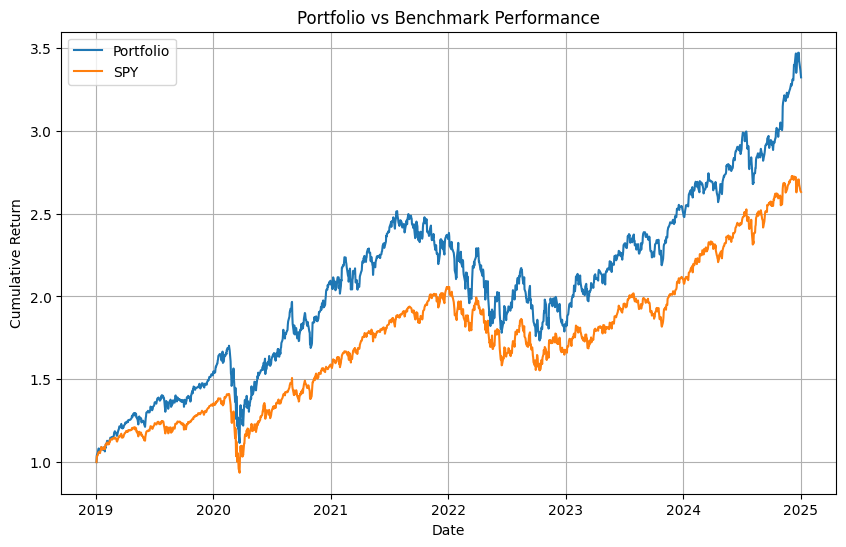

In [20]:

congressman = Congressman('Nancy Pelosi', 'D', 'H', 'CA', quiver)
# congressman.transactions
# congressman.prices
# congressman.positions
# congressman.portfolio
# congressman.weights
# congressman.returns
congressman.plot_returns()
congressman.plot_weights_sunbursts_over_time()